## 程式初始化

Import函數庫


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F




 取得GPU資訊

In [2]:
!/usr/local/cuda/bin/nvcc --version

!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
/bin/bash: nvidia-smi: command not found


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cpu'

宣告Dobot位置與軸關節公式函數(順向運動學)

In [73]:
def dobot_forword_kine(joints):

    if joints.ndim == 1:
        joints = np.expand_dims(joints, 0)

    q1 = joints[:, 0:1] # 0:1而非直接0->確保內部採用Column處理
    q2 = joints[:, 1:2]
    q3 = joints[:, 2:3]

    a2 = 135
    a3 = 147
    a4 = 61

    C1 = np.cos(q1)
    C2 = np.cos(q2)
    C23 = np.cos(q2 + q3)
    S1 = np.sin(q1)
    S2 = np.sin(q2)
    S23 = np.sin(q2 + q3)

    dx = C1 * (a3 * C23 + a2 * C2 + a4)
    dy = S1 * (a3 * C23 + a2 * C2 + a4)
    dz = -a2 * S2 - a3 * S23	

    Point = np.hstack([dx, dy, dz]) # 建立陣列
    return Point

宣告訓練資料產生函數

In [74]:
def gen_data(Train_num):
    joint_1 = (-np.pi / 2) + np.pi * np.random.rand(Train_num, 1)
    joint_2 = (-85 * np.pi / 180) + (85 * np.pi / 180) * np.random.rand(Train_num, 1)
    joint_3 = (-10 * np.pi / 180) + (105 * np.pi / 180) * np.random.rand(Train_num, 1)
    joints = np.hstack((joint_1, joint_2, joint_3))
    points = dobot_forword_kine(joints)
    return points, joints

## 建立模型
模型架構參數

In [84]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.Sequential(
                  nn.Linear(3, 10),
                  nn.BatchNorm1d(10),
                  nn.ReLU())
        self.hidden = nn.ModuleList([
                  nn.Sequential(
                    nn.Linear(10, 10),
                    nn.BatchNorm1d(10),
                    nn.ReLU()) for i in range(10)])
        self.output = nn.Linear(10,3)

    def forward(self, x):
        x = self.input(x)
        for module in self.hidden:
          x = module(x)
        x = self.output(x)
        return x
model = Net().to(device)
print(model)

Net(
  (input): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (hidden): ModuleList(
    (0-9): 10 x Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (output): Linear(in_features=10, out_features=3, bias=True)
)


**粗體文字**## 訓練流程

學習參數



In [85]:
lr = 0.0001 # 學習率.
loss_fnc = torch.nn.MSELoss()
batchsize = 16 # 批次
epochs = 150 # 
validationsplit = 0.2 # 驗證比例
datanum = 10000

自訂損失函數

In [86]:
def euclidean_distance(y_true, y_pred):
        return torch.sqrt(torch.sum(torch.square(y_true - y_pred)))

產生訓練集資料

In [87]:
x_train, y_train = gen_data(datanum)

In [88]:

train_size = int(0.8 * datanum)
valid_size = datanum - train_size

x_valid = x_train[:valid_size]
y_valid = y_train[:valid_size]
x_train = x_train[valid_size:]
y_train = y_train[valid_size:]

In [89]:
# transform to torch tensor
tensor_x_train = torch.Tensor(x_train) 
tensor_y_train = torch.Tensor(y_train)
tensor_x_valid = torch.Tensor(x_valid) 
tensor_y_valid = torch.Tensor(y_valid)


# create your datset & DataLoader
train_dataset = TensorDataset(tensor_x_train, tensor_y_train) 
train_dataloader = DataLoader(train_dataset, batch_size=batchsize) 
valid_dataset = TensorDataset(tensor_x_valid, tensor_y_valid) 
valid_dataloader = DataLoader(valid_dataset, batch_size=batchsize) 


In [90]:
# 確認dataloader
for batch_idx, (data, target) in enumerate(train_dataloader):
  if (batch_idx <1):
    print("data:",data)
    print("target:", target)

data: tensor([[ 140.7863, -230.7711,    0.5382],
        [ 174.9903,  207.2307,  186.8458],
        [  43.1625,  222.5139,  101.0718],
        [ 176.8678,  109.9223,  213.3111],
        [ 191.6783,  208.6342,  165.7504],
        [  90.6569,  183.7944,  234.8314],
        [ 127.2455, -212.6498,  210.0577],
        [ 240.0968,   24.7829,  205.2057],
        [ 306.0340,   58.9999,  128.7055],
        [ 181.4693, -235.3370,  104.2558],
        [  84.0240, -128.5982,  265.3640],
        [ 203.6002, -240.0348,  122.6024],
        [ 326.5616,  -93.2731,   40.5086],
        [ 276.7806,   99.3758,  -17.4601],
        [ 237.6394,   31.9192,  215.0756],
        [ 196.3266, -273.5963,   50.3721]])
target: tensor([[-1.0230, -0.7762,  1.4703],
        [ 0.8695, -0.8021,  0.1448],
        [ 1.3792, -1.4056,  1.6256],
        [ 0.5561, -1.3902,  0.8106],
        [ 0.8277, -0.8314,  0.3658],
        [ 1.1126, -1.2467,  0.4328],
        [-1.0316, -0.7610, -0.1590],
        [ 0.1029, -1.1112,  0.5011],
 

編譯模型

In [91]:
# 設定優化器(optimizer)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)


開始訓練

In [92]:

loss_list = []  
valid_loss_list = []  
for epoch in range(0, epochs):
    train_loss = 0.0
    correct = 0
    model.train()     # Optional when not using Model Specific layer
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        

        optimizer.zero_grad()
        output = model(data)
        loss = euclidean_distance(output,target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        
        # correct += target.eq(labels.view_as(target)).sum().item()
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in valid_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        loss = euclidean_distance(target,labels)
        valid_loss += loss.item() 

    print(f'Epoch {epoch+1} \t Training Loss: {train_loss / train_size} \t  Validation Loss: {valid_loss / valid_size}')
    loss_list.append(train_loss / train_size)
    valid_loss_list.append(valid_loss / valid_size)

Epoch 1 	 Training Loss: 0.4258978451490402 	  Validation Loss: 0.37547992897033694
Epoch 2 	 Training Loss: 0.3353686275780201 	  Validation Loss: 0.294652871131897
Epoch 3 	 Training Loss: 0.25705718287825585 	  Validation Loss: 0.23190380036830902
Epoch 4 	 Training Loss: 0.21305707654356956 	  Validation Loss: 0.2017896498441696
Epoch 5 	 Training Loss: 0.1946033409833908 	  Validation Loss: 0.1860029218196869
Epoch 6 	 Training Loss: 0.1872853026986122 	  Validation Loss: 0.1792760525941849
Epoch 7 	 Training Loss: 0.18405876514315606 	  Validation Loss: 0.17553693401813508
Epoch 8 	 Training Loss: 0.18147032330930232 	  Validation Loss: 0.1727906892299652
Epoch 9 	 Training Loss: 0.17911248002946376 	  Validation Loss: 0.17011885941028596
Epoch 10 	 Training Loss: 0.17725746999680997 	  Validation Loss: 0.16799988543987274
Epoch 11 	 Training Loss: 0.17523337753117085 	  Validation Loss: 0.1656365760564804
Epoch 12 	 Training Loss: 0.17305882108211518 	  Validation Loss: 0.163333

畫loss收斂圖

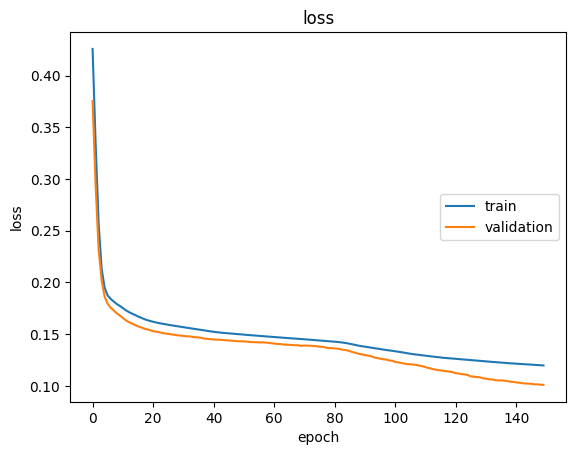

In [93]:
plt.plot(loss_list)
plt.plot(valid_loss_list)
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='center right')
plt.show()


## 自行測試

In [94]:
x_test, y_test = gen_data(20)

# transform to torch tensor
tensor_x_test = torch.Tensor(x_test) 
tensor_y_test = torch.Tensor(y_test)


# create your datset & DataLoader
test_dataset = TensorDataset(tensor_x_test, tensor_y_test) 
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False) 

In [96]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # sum up batch loss
        test_loss += euclidean_distance(output, target).item()
        

print('其中三個解:\n')
print(f'\t座標: {data[:3]},\n\t正確解: {target[:3]}\n\t預測解: {output[:3]}\n')

# 平均損失
test_loss /= len(test_dataloader.dataset)
# 顯示測試結果
data_count = len(test_dataloader.dataset)
print(f'平均損失: {test_loss:.4f}')

其中三個解:

	座標: tensor([[  56.4231, -218.9545,  175.3925],
        [  24.7849,  321.1784,   72.8488],
        [ 186.0519,  253.4659,  123.6513]]),
	正確解: tensor([[-1.3186, -1.3889,  1.0947],
        [ 1.4938, -0.5634,  0.5583],
        [ 0.9376, -0.4670,  0.0250]])
	預測解: tensor([[-0.9391, -1.2266,  1.0320],
        [ 1.2320, -0.7853,  1.0150],
        [ 0.8476, -0.7039,  0.4623]])

平均損失: 0.1088
